In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# I. Import Library

In [18]:
# import library
import os
import numpy as np
import pandas as pd
import time
import json

# Ploting library
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from dateutil.relativedelta import *


# Pytorch library
from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn,optim
import torch.nn.functional as F

In [4]:
# Opening JSON file
file_name = '/content/drive/MyDrive/Colab Notebooks/Dataset/'
with open(file_name+'char_dic.json') as json_file:
    char_dic = json.load(json_file)
    # Print the type of data variable
    print("Type:", type(char_dic))

char_dic.keys()

Type: <class 'dict'>


dict_keys(['firm_variable', 'core_firm', 'macro_variable', 'core_variable', 'label'])

# II. Prepare Data

In [5]:
file_name = '/content/drive/MyDrive/Colab Notebooks/Dataset/'
data = pd.read_pickle(file_name+'4_firm_norm_with_predicted_return.pkl')
data.insert(1, 'date',pd.to_datetime(data['jdate']).dt.to_period('Y') )
del(data['jdate'])

char_dic['firm_variable'].append('date')

X = data[char_dic['firm_variable']] # 2265038 rows × 104 columns 'yyyymm'
Y = data[['predicted_return','date']] #2265038 rows × 2 columns 'yyyymm'

In [8]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

In [9]:
sample_X_train = X[X['date']=='1980']
sample_Y_train = Y[Y['date'] == '1980']

sample_X_test = X[X['date']=='1981']
sample_Y_test = Y[Y['date'] == '1981']

In [50]:
import torch
x_train = sample_X_train.copy()
x_train = x_train.drop("date", axis=1)
x_train = torch.tensor(x_train.values, dtype = torch.float32)

y_train = sample_Y_train.copy()
y_train = y_train.drop("date", axis=1)
y_train = torch.tensor(y_train.values, dtype = torch.float32)

x_test = sample_X_test.copy()
x_test = x_test.drop("date", axis=1)
x_test= torch.tensor(x_test.values, dtype = torch.float32)

y_test = sample_Y_test.copy()
y_test = y_test.drop("date", axis=1)
y_test = torch.tensor(y_test.values, dtype = torch.float32)

# III. Define Generator and Discriminator

In [14]:
class Generator(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.gen = nn.Sequential(nn.Linear(in_features, 32),
                             nn.ReLU(True),
                             nn.Linear(32, 16),
                             nn.ReLU(True),
                             nn.Linear(16,8),
                             nn.ReLU(True),
                             nn.Linear(8, out_features),
                             nn.Tanh(),)
  def forward(self, z):
    gz = self.gen(z)
    return gz

class Discriminator(nn.Module):
  def __init__(self, in_features):
    super().__init__()
    self.disc = nn.Sequential(nn.Linear(in_features,16),
                              nn.ReLU(True),
                              nn.Linear(16,8),
                              nn.ReLU(True),
                              nn.Linear(8,1),
                              nn.Sigmoid(),)
  def forward(self, data):
    return self.disc(data)


In [55]:
dataset_train = CustomDataset(x_train, y_train)
batch_size = 5000  # Set your desired batch size
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, drop_last = False)


In [61]:
G_losses = []
D_real_loss = []
D_fake_loss = []
D_losses = []

# Define Main Function
def main_gan(train_loader):
  lr = 0.001
  num_epochs = 50
  gen = Generator(in_features = 103, out_features=1)#.to(device)
  disc = Discriminator(in_features = 1)#.to(device)
  optim_disc = optim.Adam(disc.parameters(), lr=lr, betas = (0.9,0.0999))
  optim_gen = optim.Adam(gen.parameters(), lr=lr, betas = (0.9,0.0999))
  criterion = nn.BCELoss(reduction = 'mean')

  for epoch in range(num_epochs):
    for batch_idx, (noise,real) in enumerate(train_loader):
      real = real.reshape([-1,1])
      dx = disc(real)
      loss_real = criterion(dx, torch.ones_like(dx))
      loss_real.backward()
      D_x = dx.mean().item()

      gz = gen(noise)
      dgz1 = disc(gz.detach())
      loss_fake = criterion(dgz1, torch.zeros_like(dgz1))
      loss_fake.backward()
      D_G_z1 = dgz1.mean().item()

    # calculate error D
      errorD = (loss_real + loss_fake) / 2
      optim_disc.step() # update the weights of the Disctriminator
      disc.zero_grad()

    ##############################################
    ####### Generator Backward Propagation #######
    ######### Minimize -log[D(g(z))] #############
    ##############################################
      dgz2 = disc(gz)
      errorG = criterion(dgz2, torch.ones_like(dgz2))
      errorG.backward()
      optim_gen.step() # update the weights on the Discriminator
      gen.zero_grad()
      D_G_z2 = dgz2.mean().item()

    ## Minitor the training process
      G_losses.append(errorG.item())
      D_real_loss.append(loss_real.item())
      D_fake_loss.append(loss_fake.item())
      D_losses.append(errorD.item())

      print(f'[{epoch+1}/{num_epochs}], [{batch_idx}/{len(train_loader)}]')
      print(f'Loss_D:{errorD.item()}, Loss_G:{errorG.item()}' )
      print(f'D(x):{D_x}, D(G(z)):{D_G_z1}/{D_G_z2} \n')

In [62]:
main_gan(train_loader)

[1/50], [0/10]
Loss_D:0.7004246711730957, Loss_G:0.5831505656242371
D(x):0.5584232211112976, D(G(z)):0.5587761402130127/0.5581371784210205 

[1/50], [1/10]
Loss_D:0.7007632255554199, Loss_G:0.582633376121521
D(x):0.5573397278785706, D(G(z)):0.5582175254821777/0.5584259033203125 

[1/50], [2/10]
Loss_D:0.7003744840621948, Loss_G:0.5818334221839905
D(x):0.558129072189331, D(G(z)):0.5585000514984131/0.5588728189468384 

[1/50], [3/10]
Loss_D:0.6998905539512634, Loss_G:0.5808761715888977
D(x):0.55924391746521, D(G(z)):0.5589538812637329/0.5594080090522766 

[1/50], [4/10]
Loss_D:0.6993978023529053, Loss_G:0.5797449946403503
D(x):0.5604684352874756, D(G(z)):0.5594839453697205/0.5600411891937256 

[1/50], [5/10]
Loss_D:0.6991159319877625, Loss_G:0.5782168507575989
D(x):0.5615931749343872, D(G(z)):0.5601181387901306/0.5608976483345032 

[1/50], [6/10]
Loss_D:0.7013630867004395, Loss_G:0.5769430994987488
D(x):0.5601465106010437, D(G(z)):0.5609602332115173/0.5616124868392944 

[1/50], [7/10]
Lo

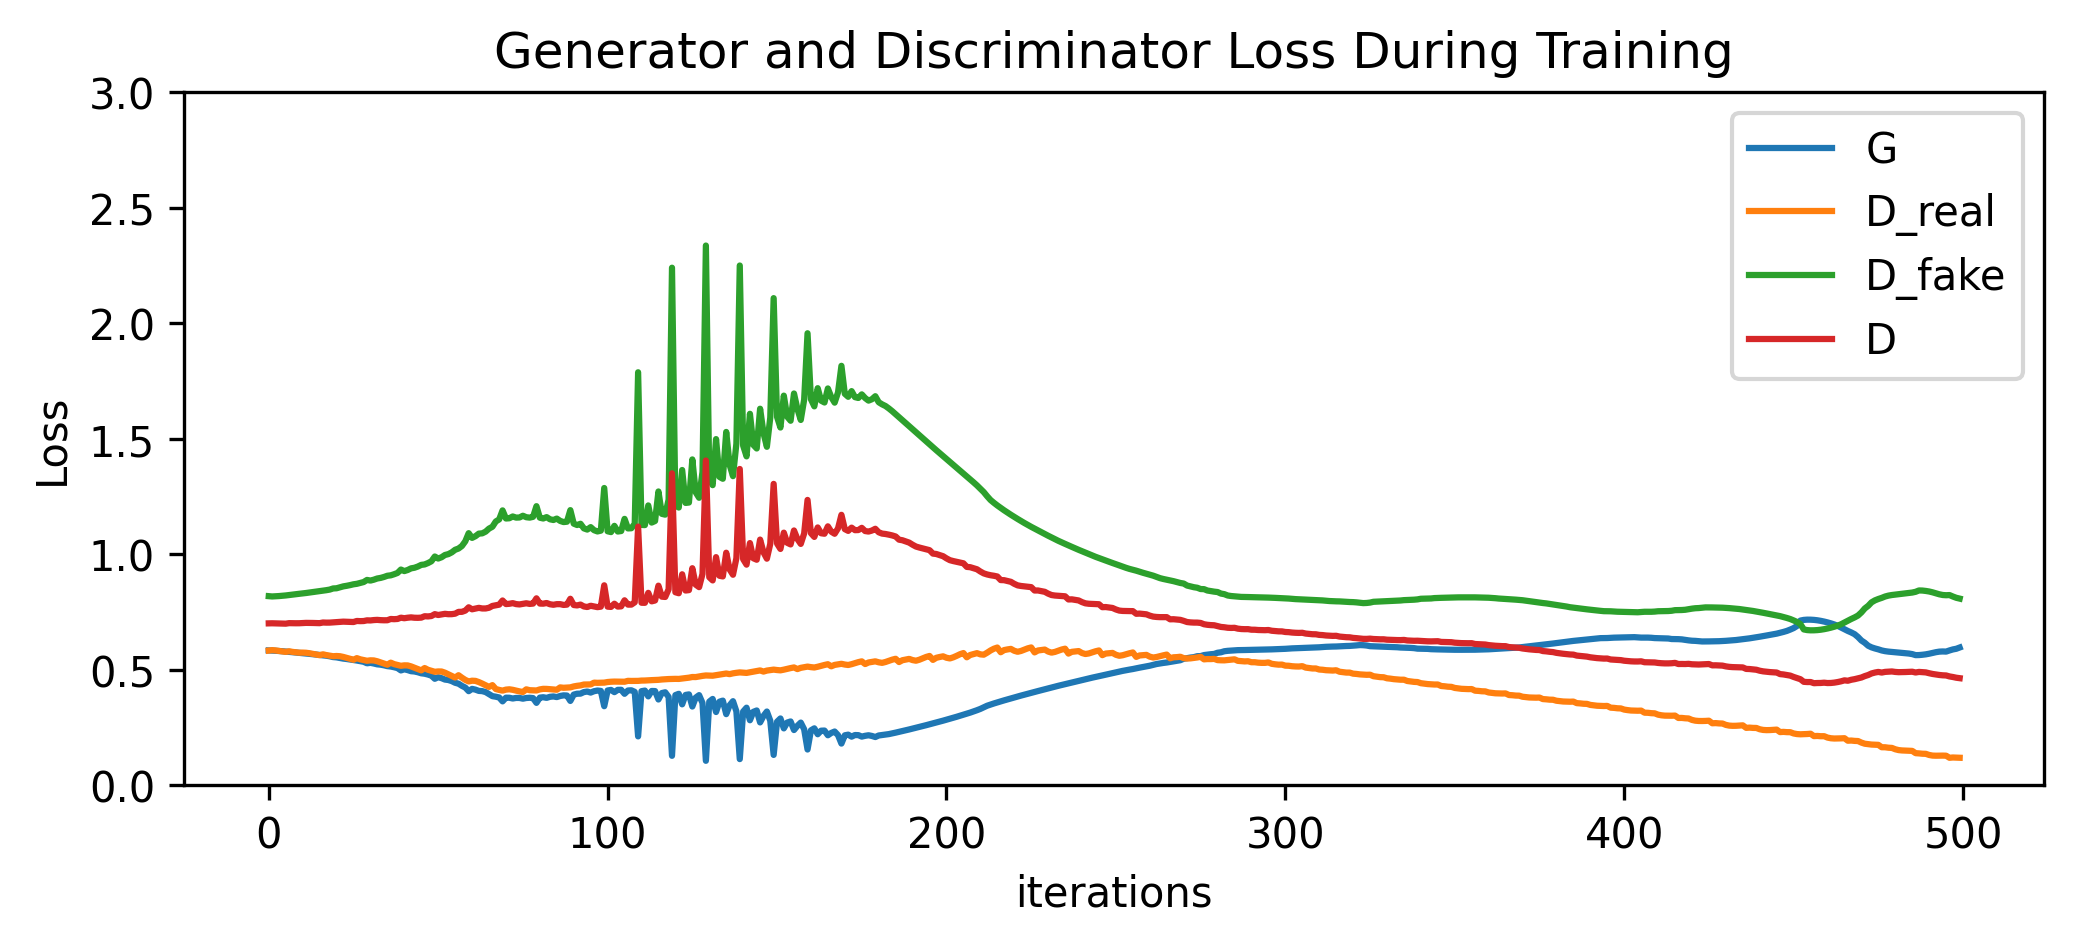

In [65]:
plt.figure(figsize =(8,3), dpi = 300)
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses, label='G')
plt.plot(D_real_loss, label='D_real')
plt.plot(D_fake_loss, label='D_fake')
plt.plot(D_losses, label='D')
plt.xlabel('iterations')
plt.ylim([0,3])
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
predict_test = gen(x_test)
predict_train = gen(x_train)

In [82]:
from sklearn.metrics import mean_squared_error

predict_test = gen(x_test)
predict_train = gen(x_train)
mse_test = mean_squared_error(y_test.detach().numpy(), predict_test.detach().numpy())
mse_train = mean_squared_error(y_train.detach().numpy(), predict_train.detach().numpy())
print(f"Mean Square Error of Train set is {mse_train}")
print(f"Mean Square Error of Test set is {mse_test}")

Mean Square Error of Train set is 0.05425100773572922
Mean Square Error of Test set is 0.05903014913201332


---

In [86]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [87]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(103, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [90]:
lr = 0.001
num_epochs = 300
generator = Generator()
discriminator = Discriminator()
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [104]:
dataset_train = CustomDataset(x_train, y_train)
batch_size = 5000  # Set your desired batch size
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, drop_last = True)

In [105]:
for epoch in range(num_epochs):
    for n, (noise, real_samples) in enumerate(train_loader):
        # Data for training the discriminator

        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = noise
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(noise)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [103]:
from sklearn.metrics import mean_squared_error

predict_test = generator(x_test)
predict_train = generator(x_train)
mse_test = mean_squared_error(y_test.detach().numpy(), predict_test.detach().numpy())
mse_train = mean_squared_error(y_train.detach().numpy(), predict_train.detach().numpy())
print(f"Mean Square Error of Train set is {mse_train}")
print(f"Mean Square Error of Test set is {mse_test}")

Mean Square Error of Train set is 0.24319647252559662
Mean Square Error of Test set is 0.24677115678787231
